XGBoost Regression - 'real-world' example: Californian Housing Dataset

https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [1]:
!pip install pyGPGO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 872 kB 23.7 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=bbb11153f9b692ee862d191e2e85a8575958d167fbbf0417343c690ebab7c29e
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=3b3c8098297468f7197494b9c173dbb0e6a2a562320cd9c3cc0cb416468beedf
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas_datareader import data

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Read data in pandas dataframe:
df_train =  pd.read_csv('/content/sample_data/california_housing_train.csv')


In [4]:
# List first rows:

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [5]:
# Remove missing data:

df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

New size: 17000


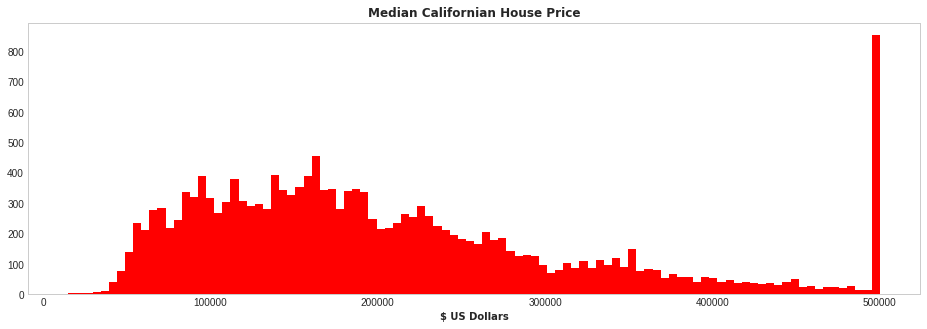

In [6]:
# Histogram fare plot:

df_train.median_house_value.hist(bins=100, figsize=(16,5), color = "red")
plt.xlabel('$ US Dollars', weight = 'bold', family = 'Arial')
plt.title('Median Californian House Price', weight = 'bold', family = 'Arial')
plt.grid(b=None)

In [7]:
y = df_train.median_house_value.values + 1e-10
y ### for supervised learning: output vector y

array([ 66900.,  80100.,  85700., ..., 103600.,  85800.,  94600.])

In [8]:
# List first rows (post-cleaning):

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [9]:
X = df_train.drop(['median_house_value'], axis = 1)
X.head() ### for supervised learning: input matrix X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


In [10]:
### Optimum rmse: regression model objective function is Root Mean Square Error (RMSE); 
### Should be minimized (as close to zero as possible):

y_global_orig = 0

In [11]:
### Bayesian Optimization - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points

util_gp = 'ERM_gp'
util_stp = 'ERM_stp'
n_init = 5 # random initialisations
opt = True

test_perc = 0.90
train_perc = 1 - test_perc

n_test = int(len(df_train) * test_perc)
n_train = int(len(df_train) - n_test)

eps = 1e-08
inverse = -1


In [12]:
### Objective function:

if obj_func == 'XGBoost': # 6-D
            
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    dim = 6
    
    max_iter = 30  # iterations of Bayesian optimization
    
    operator = 1 
    
    n_est = 5

In [13]:
n_start_AcqFunc = max_iter


In [14]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds            
        

In [15]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [16]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
    

In [17]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM_stp': self.ERM_stp,
            'ERM_gp': self.ERM_gp,
        }

        self.f = mode_dict[mode]
    
    def ERM_stp(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def ERM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [18]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [19]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [20]:
start_gp = time.time()
start_gp

1663757052.2686455

In [21]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_1 = gp_1.getResult()[0]
params_gp_1['max_depth'] = int(params_gp_1['max_depth'])
params_gp_1['min_child_weight'] = int(params_gp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_gp_test1 = xgb.DMatrix(X_test1, y_test1)
model_gp_1 = xgb.train(params_gp_1, dX_gp_train1)
pred_gp_1 = model_gp_1.predict(dX_gp_test1)

rmse_gp_1 = np.sqrt(mean_squared_error(pred_gp_1, y_test1))
rmse_gp_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.848101320876155	 0.7386468688809501	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.7469689781479785	 0.7386468688809501	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8079963708366673	 0.7386468688809501	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.7386468688809501	 0.7386468688809501	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.937768916815817	 0.7386468688809501	    	    
1  	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]	 0.8126185461054997	 0.7386468688809501	 5.054981505322587	 5.067884513559563
2  	 [ 0.74723898  0.36469704 11.          0.84902862 15.          0.10419698]	 0.9318704004

59912.05597064799

In [22]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_2 = gp_2.getResult()[0]
params_gp_2['max_depth'] = int(params_gp_2['max_depth'])
params_gp_2['min_child_weight'] = int(params_gp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_gp_test2 = xgb.DMatrix(X_test2, y_test2)
model_gp_2 = xgb.train(params_gp_2, dX_gp_train2)
pred_gp_2 = model_gp_2.predict(dX_gp_test2)

rmse_gp_2 = np.sqrt(mean_squared_error(pred_gp_2, y_test2))
rmse_gp_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.9157817005982263	 0.8490988745111359	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.8517975125315337	 0.8490988745111359	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8490988745111359	 0.8490988745111359	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.9839177202713774	 0.8490988745111359	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.9688138526063573	 0.8490988745111359	    	    
1	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]	 0.7933779577878181	 0.7933779577878181	 4.317853012085762	 4.356008819173959
2	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]	 0.775347004417

61286.16435498987

In [23]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_3 = gp_3.getResult()[0]
params_gp_3['max_depth'] = int(params_gp_3['max_depth'])
params_gp_3['min_child_weight'] = int(params_gp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_gp_test3 = xgb.DMatrix(X_test3, y_test3)
model_gp_3 = xgb.train(params_gp_3, dX_gp_train3)
pred_gp_3 = model_gp_3.predict(dX_gp_test3)

rmse_gp_3 = np.sqrt(mean_squared_error(pred_gp_3, y_test3))
rmse_gp_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 1.1001019572672721	 0.8205570570239384	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 1.0968690738660336	 0.8205570570239384	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.8205570570239384	 0.8205570570239384	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 1.0984076753833096	 0.8205570570239384	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.8540219347978375	 0.8205570570239384	    	    
1  	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]	 0.8296591774144556	 0.8205570570239384	 4.74388397306464	 4.6984396600087335
2	 [ 2.46535469  7.06056184  5.          0.53518488 13.          0.98930148]	 0.8159546965

59117.95352067002

In [24]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

gp_4 = dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_4 = gp_4.getResult()[0]
params_gp_4['max_depth'] = int(params_gp_4['max_depth'])
params_gp_4['min_child_weight'] = int(params_gp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_gp_test4 = xgb.DMatrix(X_test4, y_test4)
model_gp_4 = xgb.train(params_gp_4, dX_gp_train4)
pred_gp_4 = model_gp_4.predict(dX_gp_test4)

rmse_gp_4 = np.sqrt(mean_squared_error(pred_gp_4, y_test4))
rmse_gp_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.7650622398140196	 0.7505823286451517	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.7710732234684645	 0.7505823286451517	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 1.127900018061083	 0.7505823286451517	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.7505823286451517	 0.7505823286451517	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.9579573664970923	 0.7505823286451517	    	    
1  	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]	 1.1269429525174437	 0.7505823286451517	 4.87370563393193	 4.848755153427557
2  	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]	 0.8738592566

60386.406104184076

In [25]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_5 = gp_5.getResult()[0]
params_gp_5['max_depth'] = int(params_gp_5['max_depth'])
params_gp_5['min_child_weight'] = int(params_gp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_gp_test5 = xgb.DMatrix(X_test5, y_test5)
model_gp_5 = xgb.train(params_gp_5, dX_gp_train5)
pred_gp_5 = model_gp_5.predict(dX_gp_test5)

rmse_gp_5 = np.sqrt(mean_squared_error(pred_gp_5, y_test5))
rmse_gp_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.7978949387548113	 0.7689238087022429	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.7689238087022429	 0.7689238087022429	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.9009085979032214	 0.7689238087022429	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.9616956128686873	 0.7689238087022429	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.8968042534595716	 0.7689238087022429	    	    
1  	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]	 0.9141640599232991	 0.7689238087022429	 4.777499745091511	 4.763970789689953
2  	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]	 0.96573027532328

59612.82267483437

In [26]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_6 = gp_6.getResult()[0]
params_gp_6['max_depth'] = int(params_gp_6['max_depth'])
params_gp_6['min_child_weight'] = int(params_gp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_gp_test6 = xgb.DMatrix(X_test6, y_test6)
model_gp_6 = xgb.train(params_gp_6, dX_gp_train6)
pred_gp_6 = model_gp_6.predict(dX_gp_test6)

rmse_gp_6 = np.sqrt(mean_squared_error(pred_gp_6, y_test6))
rmse_gp_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.8708842589582968	 0.8009237324889021	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.868843701878103	 0.8009237324889021	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.8009237324889021	 0.8009237324889021	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8412285708806564	 0.8009237324889021	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 1.0874405633037085	 0.8009237324889021	    	    
1  	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]	 1.077285755760575	 0.8009237324889021	 4.484539436415457	 4.471395194635607
2  	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]	 1.1030510584286708	 0.80

60137.230725617366

In [27]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_7 = gp_7.getResult()[0]
params_gp_7['max_depth'] = int(params_gp_7['max_depth'])
params_gp_7['min_child_weight'] = int(params_gp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_gp_test7 = xgb.DMatrix(X_test7, y_test7)
model_gp_7 = xgb.train(params_gp_7, dX_gp_train7)
pred_gp_7 = model_gp_7.predict(dX_gp_test7)

rmse_gp_7 = np.sqrt(mean_squared_error(pred_gp_7, y_test7))
rmse_gp_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.7260880637055529	 0.7260880637055529	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.7424588384015385	 0.7260880637055529	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.8412720456029797	 0.7260880637055529	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.7736412232573235	 0.7260880637055529	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.7650415360356615	 0.7260880637055529	    	    
1  	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]	 0.9222990750260575	 0.7260880637055529	 4.939355292636296	 4.931913999206691
2  	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]	 0.7908681556639724	 0.

59954.44736483102

In [28]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_8 = gp_8.getResult()[0]
params_gp_8['max_depth'] = int(params_gp_8['max_depth'])
params_gp_8['min_child_weight'] = int(params_gp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_gp_test8 = xgb.DMatrix(X_test8, y_test8)
model_gp_8 = xgb.train(params_gp_8, dX_gp_train8)
pred_gp_8 = model_gp_8.predict(dX_gp_test8)

rmse_gp_8 = np.sqrt(mean_squared_error(pred_gp_8, y_test8))
rmse_gp_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.802823873653181	 0.7393694249818598	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.7439561063387327	 0.7393694249818598	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.8573744170126428	 0.7393694249818598	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.7605799870908501	 0.7393694249818598	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.7393694249818598	 0.7393694249818598	    	    
1	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]	 0.7341650428609557	 0.7341650428609557	 4.976337157935393	 4.991379359557909
2  	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]	 0.88730870468

59394.6160637996

In [29]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_9 = gp_9.getResult()[0]
params_gp_9['max_depth'] = int(params_gp_9['max_depth'])
params_gp_9['min_child_weight'] = int(params_gp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_gp_test9 = xgb.DMatrix(X_test9, y_test9)
model_gp_9 = xgb.train(params_gp_9, dX_gp_train9)
pred_gp_9 = model_gp_9.predict(dX_gp_test9)

rmse_gp_9 = np.sqrt(mean_squared_error(pred_gp_9, y_test9))
rmse_gp_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 1.1242573295906948	 0.7785306461595496	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 1.1029639839305116	 0.7785306461595496	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.7785306461595496	 0.7785306461595496	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.8502721808074817	 0.7785306461595496	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.8007936005920335	 0.7785306461595496	    	    
1  	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]	 1.1406566629866908	 0.7785306461595496	 5.050806971730395	 5.038162836886283
2  	 [9.23885705 0.0495141  9.         0.5847098  7.         0.79832927]	 0.86802216675792

60771.44993052721

In [30]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_10 = gp_10.getResult()[0]
params_gp_10['max_depth'] = int(params_gp_10['max_depth'])
params_gp_10['min_child_weight'] = int(params_gp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_gp_test10 = xgb.DMatrix(X_test10, y_test10)
model_gp_10 = xgb.train(params_gp_10, dX_gp_train10)
pred_gp_10 = model_gp_10.predict(dX_gp_test10)

rmse_gp_10 = np.sqrt(mean_squared_error(pred_gp_10, y_test10))
rmse_gp_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 1.0639310256047103	 0.7797034870948047	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.79580179662759	 0.7797034870948047	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.7797034870948047	 0.7797034870948047	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.7990514117028104	 0.7797034870948047	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 1.0587036817796267	 0.7797034870948047	    	    
1	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]	 0.7741723447560037	 0.7741723447560037	 4.602606655749082	 4.610092339694974
2  	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]	 0.8572799307158145	 

60178.06298836527

In [31]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_11 = gp_11.getResult()[0]
params_gp_11['max_depth'] = int(params_gp_11['max_depth'])
params_gp_11['min_child_weight'] = int(params_gp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_gp_test11 = xgb.DMatrix(X_test11, y_test11)
model_gp_11 = xgb.train(params_gp_11, dX_gp_train11)
pred_gp_11 = model_gp_11.predict(dX_gp_test11)

rmse_gp_11 = np.sqrt(mean_squared_error(pred_gp_11, y_test11))
rmse_gp_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8177825188141039	 0.7287337628426743	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.7419480115539112	 0.7287337628426743	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.7287337628426743	 0.7287337628426743	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.7335645848611818	 0.7287337628426743	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.7441537376931249	 0.7287337628426743	    	    
1  	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]	 0.7482694480200888	 0.7287337628426743	 4.242640675859494	 4.160510015779617
2	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]	 0.7070648622

61646.85412299576

In [32]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_12 = gp_12.getResult()[0]
params_gp_12['max_depth'] = int(params_gp_12['max_depth'])
params_gp_12['min_child_weight'] = int(params_gp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_gp_test12 = xgb.DMatrix(X_test12, y_test12)
model_gp_12 = xgb.train(params_gp_12, dX_gp_train12)
pred_gp_12 = model_gp_12.predict(dX_gp_test12)

rmse_gp_12 = np.sqrt(mean_squared_error(pred_gp_12, y_test12))
rmse_gp_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.992708970032886	 0.7896346786115067	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.9050380263035862	 0.7896346786115067	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.8362986807103934	 0.7896346786115067	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.7896346786115067	 0.7896346786115067	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.9186387829358221	 0.7896346786115067	    	    
1  	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]	 0.8115376813007883	 0.7896346786115067	 4.721988501532786	 4.686006175557566
2  	 [ 3.78385301  2.21923666 12.          0.57141407  8.          0.55842631]	 0.860004576914597

61494.6504599855

In [33]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_13 = gp_13.getResult()[0]
params_gp_13['max_depth'] = int(params_gp_13['max_depth'])
params_gp_13['min_child_weight'] = int(params_gp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_gp_test13 = xgb.DMatrix(X_test13, y_test13)
model_gp_13 = xgb.train(params_gp_13, dX_gp_train13)
pred_gp_13 = model_gp_13.predict(dX_gp_test13)

rmse_gp_13 = np.sqrt(mean_squared_error(pred_gp_13, y_test13))
rmse_gp_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.7315012035187541	 0.7315012035187541	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 1.1319770010327717	 0.7315012035187541	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.9318565354152348	 0.7315012035187541	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.7799608780638936	 0.7315012035187541	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 1.1305934464937346	 0.7315012035187541	    	    
1  	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]	 0.7922048089873084	 0.7315012035187541	 4.999373676694092	 4.978163131948185
2	 [10.          8.63469032 15.          1.         20.          1.        ]	 0.7284779445

59681.985318557156

In [34]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_14 = gp_14.getResult()[0]
params_gp_14['max_depth'] = int(params_gp_14['max_depth'])
params_gp_14['min_child_weight'] = int(params_gp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_gp_test14 = xgb.DMatrix(X_test14, y_test14)
model_gp_14 = xgb.train(params_gp_14, dX_gp_train14)
pred_gp_14 = model_gp_14.predict(dX_gp_test14)

rmse_gp_14 = np.sqrt(mean_squared_error(pred_gp_14, y_test14))
rmse_gp_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.886516450243748	 0.7696523735238344	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.8159404842786963	 0.7696523735238344	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.9077084280320982	 0.7696523735238344	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.7696523735238344	 0.7696523735238344	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.9767143382937844	 0.7696523735238344	    	    
1  	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]	 0.9945462140035275	 0.7696523735238344	 4.806642344813053	 4.820320945270334
2	 [10. 10. 15.  1. 20.  1.]	 0.754288614897578	 0.754288614897578	 5.1006801284079035	 4.9

60569.20712257925

In [35]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_15 = gp_15.getResult()[0]
params_gp_15['max_depth'] = int(params_gp_15['max_depth'])
params_gp_15['min_child_weight'] = int(params_gp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_gp_test15 = xgb.DMatrix(X_test15, y_test15)
model_gp_15 = xgb.train(params_gp_15, dX_gp_train15)
pred_gp_15 = model_gp_15.predict(dX_gp_test15)

rmse_gp_15 = np.sqrt(mean_squared_error(pred_gp_15, y_test15))
rmse_gp_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.7846478010899064	 0.7846478010899064	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 1.0448868808294456	 0.7846478010899064	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 1.0327067294213346	 0.7846478010899064	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8536879526704689	 0.7846478010899064	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 1.0323325469581077	 0.7846478010899064	    	    
1  	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]	 0.810550884613735	 0.7846478010899064	 4.927018687962268	 4.927018576649561
2  	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]	 0.953508826526354

61974.57214376832

In [36]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_16 = gp_16.getResult()[0]
params_gp_16['max_depth'] = int(params_gp_16['max_depth'])
params_gp_16['min_child_weight'] = int(params_gp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_gp_test16 = xgb.DMatrix(X_test16, y_test16)
model_gp_16 = xgb.train(params_gp_16, dX_gp_train16)
pred_gp_16 = model_gp_16.predict(dX_gp_test16)

rmse_gp_16 = np.sqrt(mean_squared_error(pred_gp_16, y_test16))
rmse_gp_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 1.0442882316794924	 0.9988899440522335	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 1.034592364984854	 0.9988899440522335	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.9988899440522335	 0.9988899440522335	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 1.0616382201607613	 0.9988899440522335	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 1.0586655163441985	 0.9988899440522335	    	    
1	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]	 0.7588724777099193	 0.7588724777099193	 4.918632060035707	 4.951425391169882
2  	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]	 1.0357720753154218	

60620.752169383864

In [37]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_17 = gp_17.getResult()[0]
params_gp_17['max_depth'] = int(params_gp_17['max_depth'])
params_gp_17['min_child_weight'] = int(params_gp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_gp_test17 = xgb.DMatrix(X_test17, y_test17)
model_gp_17 = xgb.train(params_gp_17, dX_gp_train17)
pred_gp_17 = model_gp_17.predict(dX_gp_test17)

rmse_gp_17 = np.sqrt(mean_squared_error(pred_gp_17, y_test17))
rmse_gp_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.8160193762021096	 0.8160193762021096	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.9345750435828236	 0.8160193762021096	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.8609997448649105	 0.8160193762021096	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.9816665199899536	 0.8160193762021096	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.9568167510294832	 0.8160193762021096	    	    
1  	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]	 0.9860041719301801	 0.8160193762021096	 4.748260712241218	 4.662474472947969
2  	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]	 0.84188384018784

59861.897599950054

In [38]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_18 = gp_18.getResult()[0]
params_gp_18['max_depth'] = int(params_gp_18['max_depth'])
params_gp_18['min_child_weight'] = int(params_gp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_gp_test18 = xgb.DMatrix(X_test18, y_test18)
model_gp_18 = xgb.train(params_gp_18, dX_gp_train18)
pred_gp_18 = model_gp_18.predict(dX_gp_test18)

rmse_gp_18 = np.sqrt(mean_squared_error(pred_gp_18, y_test18))
rmse_gp_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.9945504564494708	 0.8040972705253946	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.8040972705253946	 0.8040972705253946	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.9800705737387579	 0.8040972705253946	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8208145553024886	 0.8040972705253946	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.8099770295888573	 0.8040972705253946	    	    
1  	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]	 0.8290526771960891	 0.8040972705253946	 4.765549863917277	 4.6424476552218445
2	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]	 0.7717526578038573	 0.7

60191.05447079106

In [39]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_19 = gp_19.getResult()[0]
params_gp_19['max_depth'] = int(params_gp_19['max_depth'])
params_gp_19['min_child_weight'] = int(params_gp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_gp_test19 = xgb.DMatrix(X_test19, y_test19)
model_gp_19 = xgb.train(params_gp_19, dX_gp_train19)
pred_gp_19 = model_gp_19.predict(dX_gp_test19)

rmse_gp_19 = np.sqrt(mean_squared_error(pred_gp_19, y_test19))
rmse_gp_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.9238143360620997	 0.824729580989813	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9119597092034326	 0.824729580989813	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 1.1280473533716002	 0.824729580989813	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.885331313733569	 0.824729580989813	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.824729580989813	 0.824729580989813	    	    
1	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]	 0.79346025102973	 0.79346025102973	 5.061617584788491	 4.911248956500029
2  	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]	 0.8875735409405836	 0.7

61929.7345984914

In [40]:
### Bayesian optimization runs (x20): 'Exact GP ERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_20 = gp_20.getResult()[0]
params_gp_20['max_depth'] = int(params_gp_20['max_depth'])
params_gp_20['min_child_weight'] = int(params_gp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_gp_test20 = xgb.DMatrix(X_test20, y_test20)
model_gp_20 = xgb.train(params_gp_20, dX_gp_train20)
pred_gp_20 = model_gp_20.predict(dX_gp_test20)

rmse_gp_20 = np.sqrt(mean_squared_error(pred_gp_20, y_test20))
rmse_gp_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.7520109919120059	 0.7520109919120059	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.7843437690505969	 0.7520109919120059	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 1.0380897569172567	 0.7520109919120059	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.9185289289653313	 0.7520109919120059	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.9180724641961298	 0.7520109919120059	    	    
1  	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]	 0.9254670555638643	 0.7520109919120059	 4.876693171082517	 4.876693171082517
2  	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]	 1.03146314

59259.8898917507

In [41]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663758821.9346652

In [42]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_1 = stp_1.getResult()[0]
params_stp_1['max_depth'] = int(params_stp_1['max_depth'])
params_stp_1['min_child_weight'] = int(params_stp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_stp_test1 = xgb.DMatrix(X_test1, y_test1)
model_stp_1 = xgb.train(params_stp_1, dX_stp_train1)
pred_stp_1 = model_stp_1.predict(dX_stp_test1)

rmse_stp_1 = np.sqrt(mean_squared_error(pred_stp_1, y_test1))
rmse_stp_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.848101320876155	 0.7386468688809501	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.7469689781479785	 0.7386468688809501	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8079963708366673	 0.7386468688809501	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.7386468688809501	 0.7386468688809501	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.937768916815817	 0.7386468688809501	    	    
1  	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]	 0.8126185461054997	 0.7386468688809501	 5.056465011377189	 5.066625442406068
2  	 [ 0.74723898  0.36469704 11.          0.84902862 15.          0.10419698]	 0.93187

59912.05597064799

In [43]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_2 = stp_2.getResult()[0]
params_stp_2['max_depth'] = int(params_stp_2['max_depth'])
params_stp_2['min_child_weight'] = int(params_stp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_stp_test2 = xgb.DMatrix(X_test2, y_test2)
model_stp_2 = xgb.train(params_stp_2, dX_stp_train2)
pred_stp_2 = model_stp_2.predict(dX_stp_test2)

rmse_stp_2 = np.sqrt(mean_squared_error(pred_stp_2, y_test2))
rmse_stp_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.9157817005982263	 0.8490988745111359	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.8517975125315337	 0.8490988745111359	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8490988745111359	 0.8490988745111359	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.9839177202713774	 0.8490988745111359	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.9688138526063573	 0.8490988745111359	    	    
1	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]	 0.7933779577878181	 0.7933779577878181	 4.361017573097529	 4.357580835598254
2  	 [0.  0.  5.  0.5 1.  0.1]	 1.0080537575046533	 0.7933779577878181	 5.0360973083973

61271.33790054691

In [44]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_3 = stp_3.getResult()[0]
params_stp_3['max_depth'] = int(params_stp_3['max_depth'])
params_stp_3['min_child_weight'] = int(params_stp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_stp_test3 = xgb.DMatrix(X_test3, y_test3)
model_stp_3 = xgb.train(params_stp_3, dX_stp_train3)
pred_stp_3 = model_stp_3.predict(dX_stp_test3)

rmse_stp_3 = np.sqrt(mean_squared_error(pred_stp_3, y_test3))
rmse_stp_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 1.1001019572672721	 0.8205570570239384	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 1.0968690738660336	 0.8205570570239384	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.8205570570239384	 0.8205570570239384	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 1.0984076753833096	 0.8205570570239384	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.8540219347978375	 0.8205570570239384	    	    
1  	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]	 0.8296591774144556	 0.8205570570239384	 4.703479213283349	 4.698150483429055
2	 [ 2.46535469  7.06056184  5.          0.53518488 13.          0.98930148]	 0.81595

58928.58286242264

In [45]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_4 = stp_4.getResult()[0]
params_stp_4['max_depth'] = int(params_stp_4['max_depth'])
params_stp_4['min_child_weight'] = int(params_stp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_stp_test4 = xgb.DMatrix(X_test4, y_test4)
model_stp_4 = xgb.train(params_stp_4, dX_stp_train4)
pred_stp_4 = model_stp_4.predict(dX_stp_test4)

rmse_stp_4 = np.sqrt(mean_squared_error(pred_stp_4, y_test4))
rmse_stp_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.7650622398140196	 0.7505823286451517	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.7710732234684645	 0.7505823286451517	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 1.127900018061083	 0.7505823286451517	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.7505823286451517	 0.7505823286451517	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.9579573664970923	 0.7505823286451517	    	    
1  	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]	 1.1269429525174437	 0.7505823286451517	 4.838090283384171	 4.850326211581803
2  	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]	 0.8738

60704.61563689397

In [46]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_5 = stp_5.getResult()[0]
params_stp_5['max_depth'] = int(params_stp_5['max_depth'])
params_stp_5['min_child_weight'] = int(params_stp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_stp_test5 = xgb.DMatrix(X_test5, y_test5)
model_stp_5 = xgb.train(params_stp_5, dX_stp_train5)
pred_stp_5 = model_stp_5.predict(dX_stp_test5)

rmse_stp_5 = np.sqrt(mean_squared_error(pred_stp_5, y_test5))
rmse_stp_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.7978949387548113	 0.7689238087022429	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.7689238087022429	 0.7689238087022429	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.9009085979032214	 0.7689238087022429	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.9616956128686873	 0.7689238087022429	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.8968042534595716	 0.7689238087022429	    	    
1  	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]	 0.9141640599232991	 0.7689238087022429	 4.8196580479801066	 4.765568380653731
2  	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]	 0.96573027

59989.37417909926

In [47]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror', eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_6 = stp_6.getResult()[0]
params_stp_6['max_depth'] = int(params_stp_6['max_depth'])
params_stp_6['min_child_weight'] = int(params_stp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_stp_test6 = xgb.DMatrix(X_test6, y_test6)
model_stp_6 = xgb.train(params_stp_6, dX_stp_train6)
pred_stp_6 = model_stp_6.predict(dX_stp_test6)

rmse_stp_6 = np.sqrt(mean_squared_error(pred_stp_6, y_test6))
rmse_stp_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.8708842589582968	 0.8009237324889021	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.868843701878103	 0.8009237324889021	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.8009237324889021	 0.8009237324889021	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8412285708806564	 0.8009237324889021	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 1.0874405633037085	 0.8009237324889021	    	    
1  	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]	 1.077285755760575	 0.8009237324889021	 4.460218554640672	 4.470766001391072
2  	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]	 1.1030510584286708	

58927.217755027166

In [48]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_7 = stp_7.getResult()[0]
params_stp_7['max_depth'] = int(params_stp_7['max_depth'])
params_stp_7['min_child_weight'] = int(params_stp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_stp_test7 = xgb.DMatrix(X_test7, y_test7)
model_stp_7 = xgb.train(params_stp_7, dX_stp_train7)
pred_stp_7 = model_stp_7.predict(dX_stp_test7)

rmse_stp_7 = np.sqrt(mean_squared_error(pred_stp_7, y_test7))
rmse_stp_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.7260880637055529	 0.7260880637055529	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.7424588384015385	 0.7260880637055529	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.8412720456029797	 0.7260880637055529	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.7736412232573235	 0.7260880637055529	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.7650415360356615	 0.7260880637055529	    	    
1  	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]	 0.9222990750260575	 0.7260880637055529	 4.931796154993013	 4.932599911624951
2  	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]	 0.790868155663972

59954.44736483102

In [49]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_8 = stp_8.getResult()[0]
params_stp_8['max_depth'] = int(params_stp_8['max_depth'])
params_stp_8['min_child_weight'] = int(params_stp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_stp_test8 = xgb.DMatrix(X_test8, y_test8)
model_stp_8 = xgb.train(params_stp_8, dX_stp_train8)
pred_stp_8 = model_stp_8.predict(dX_stp_test8)

rmse_stp_8 = np.sqrt(mean_squared_error(pred_stp_8, y_test8))
rmse_stp_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.802823873653181	 0.7393694249818598	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.7439561063387327	 0.7393694249818598	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.8573744170126428	 0.7393694249818598	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.7605799870908501	 0.7393694249818598	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.7393694249818598	 0.7393694249818598	    	    
1	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]	 0.7341650428609557	 0.7341650428609557	 4.976267918166572	 5.007147290351994
2  	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]	 0.887308

59493.46322622606

In [50]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_9 = stp_9.getResult()[0]
params_stp_9['max_depth'] = int(params_stp_9['max_depth'])
params_stp_9['min_child_weight'] = int(params_stp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_stp_test9 = xgb.DMatrix(X_test9, y_test9)
model_stp_9 = xgb.train(params_stp_9, dX_stp_train9)
pred_stp_9 = model_stp_9.predict(dX_stp_test9)

rmse_stp_9 = np.sqrt(mean_squared_error(pred_stp_9, y_test9))
rmse_stp_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 1.1242573295906948	 0.7785306461595496	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 1.1029639839305116	 0.7785306461595496	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.7785306461595496	 0.7785306461595496	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.8502721808074817	 0.7785306461595496	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.8007936005920335	 0.7785306461595496	    	    
1  	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]	 1.1406566629866908	 0.7785306461595496	 5.050709576611929	 5.036259902728974
2  	 [9.23885705 0.0495141  9.         0.5847098  7.         0.79832927]	 0.868022166

58909.59940760899

In [51]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_10 = stp_10.getResult()[0]
params_stp_10['max_depth'] = int(params_stp_10['max_depth'])
params_stp_10['min_child_weight'] = int(params_stp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_stp_test10 = xgb.DMatrix(X_test10, y_test10)
model_stp_10 = xgb.train(params_stp_10, dX_stp_train10)
pred_stp_10 = model_stp_10.predict(dX_stp_test10)

rmse_stp_10 = np.sqrt(mean_squared_error(pred_stp_10, y_test10))
rmse_stp_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 1.0639310256047103	 0.7797034870948047	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.79580179662759	 0.7797034870948047	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.7797034870948047	 0.7797034870948047	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.7990514117028104	 0.7797034870948047	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 1.0587036817796267	 0.7797034870948047	    	    
1	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]	 0.7741723447560037	 0.7741723447560037	 4.603356149478018	 4.610664925095062
2  	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]	 0.8572799307158

60178.06298836527

In [52]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_11 = stp_11.getResult()[0]
params_stp_11['max_depth'] = int(params_stp_11['max_depth'])
params_stp_11['min_child_weight'] = int(params_stp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_stp_test11 = xgb.DMatrix(X_test11, y_test11)
model_stp_11 = xgb.train(params_stp_11, dX_stp_train11)
pred_stp_11 = model_stp_11.predict(dX_stp_test11)

rmse_stp_11 = np.sqrt(mean_squared_error(pred_stp_11, y_test11))
rmse_stp_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8177825188141039	 0.7287337628426743	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.7419480115539112	 0.7287337628426743	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.7287337628426743	 0.7287337628426743	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.7335645848611818	 0.7287337628426743	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.7441537376931249	 0.7287337628426743	    	    
1  	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]	 0.7482694480200888	 0.7287337628426743	 4.18824629217855	 4.15914778444529
2	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]	 0.7070648

60589.21573009441

In [53]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_12 = stp_12.getResult()[0]
params_stp_12['max_depth'] = int(params_stp_12['max_depth'])
params_stp_12['min_child_weight'] = int(params_stp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_stp_test12 = xgb.DMatrix(X_test12, y_test12)
model_stp_12 = xgb.train(params_stp_12, dX_stp_train12)
pred_stp_12 = model_stp_12.predict(dX_stp_test12)

rmse_stp_12 = np.sqrt(mean_squared_error(pred_stp_12, y_test12))
rmse_stp_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.992708970032886	 0.7896346786115067	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.9050380263035862	 0.7896346786115067	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.8362986807103934	 0.7896346786115067	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.7896346786115067	 0.7896346786115067	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.9186387829358221	 0.7896346786115067	    	    
1  	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]	 0.8115376813007883	 0.7896346786115067	 4.707889270878172	 4.688624141646176
2	 [10. 10. 15.  1. 20.  1.]	 0.7706848965834242	 0.7706848965834242	 5.222670312875896	 5.1

60865.80948165841

In [54]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_13 = stp_13.getResult()[0]
params_stp_13['max_depth'] = int(params_stp_13['max_depth'])
params_stp_13['min_child_weight'] = int(params_stp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_stp_test13 = xgb.DMatrix(X_test13, y_test13)
model_stp_13 = xgb.train(params_stp_13, dX_stp_train13)
pred_stp_13 = model_stp_13.predict(dX_stp_test13)

rmse_stp_13 = np.sqrt(mean_squared_error(pred_stp_13, y_test13))
rmse_stp_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.7315012035187541	 0.7315012035187541	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 1.1319770010327717	 0.7315012035187541	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.9318565354152348	 0.7315012035187541	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.7799608780638936	 0.7315012035187541	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 1.1305934464937346	 0.7315012035187541	    	    
1  	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]	 0.7922048089873084	 0.7315012035187541	 4.998314926228648	 4.978566938432968
2  	 [6.93463528 1.25795731 8.         0.92695971 3.         0.9534311 ]	 0.736400936

59681.985318557156

In [55]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_14 = stp_14.getResult()[0]
params_stp_14['max_depth'] = int(params_stp_14['max_depth'])
params_stp_14['min_child_weight'] = int(params_stp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_stp_test14 = xgb.DMatrix(X_test14, y_test14)
model_stp_14 = xgb.train(params_stp_14, dX_stp_train14)
pred_stp_14 = model_stp_14.predict(dX_stp_test14)

rmse_stp_14 = np.sqrt(mean_squared_error(pred_stp_14, y_test14))
rmse_stp_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.886516450243748	 0.7696523735238344	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.8159404842786963	 0.7696523735238344	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.9077084280320982	 0.7696523735238344	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.7696523735238344	 0.7696523735238344	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.9767143382937844	 0.7696523735238344	    	    
1	 [10. 10. 15.  1. 20.  1.]	 0.754288614897578	 0.754288614897578	 5.020910869966513	 4.8207807743603786
2  	 [ 7.76634288  3.97321246 10.          0.55609776  2.          0.23355983]	 0.9893793311448921	 0.754288614897578	 4.995111850622105	

60991.061415004544

In [56]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_15 = stp_15.getResult()[0]
params_stp_15['max_depth'] = int(params_stp_15['max_depth'])
params_stp_15['min_child_weight'] = int(params_stp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_stp_test15 = xgb.DMatrix(X_test15, y_test15)
model_stp_15 = xgb.train(params_stp_15, dX_stp_train15)
pred_stp_15 = model_stp_15.predict(dX_stp_test15)

rmse_stp_15 = np.sqrt(mean_squared_error(pred_stp_15, y_test15))
rmse_stp_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.7846478010899064	 0.7846478010899064	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 1.0448868808294456	 0.7846478010899064	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 1.0327067294213346	 0.7846478010899064	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8536879526704689	 0.7846478010899064	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 1.0323325469581077	 0.7846478010899064	    	    
1  	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]	 0.810550884613735	 0.7846478010899064	 4.927018687962268	 4.927018576679669
2  	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]	 0.9535088265

61931.472044342285

In [57]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_16 = stp_16.getResult()[0]
params_stp_16['max_depth'] = int(params_stp_16['max_depth'])
params_stp_16['min_child_weight'] = int(params_stp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_stp_test16 = xgb.DMatrix(X_test16, y_test16)
model_stp_16 = xgb.train(params_stp_16, dX_stp_train16)
pred_stp_16 = model_stp_16.predict(dX_stp_test16)

rmse_stp_16 = np.sqrt(mean_squared_error(pred_stp_16, y_test16))
rmse_stp_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 1.0442882316794924	 0.9988899440522335	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 1.034592364984854	 0.9988899440522335	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.9988899440522335	 0.9988899440522335	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 1.0616382201607613	 0.9988899440522335	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 1.0586655163441985	 0.9988899440522335	    	    
1	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]	 0.7588724777099193	 0.7588724777099193	 4.911791265843314	 4.950935379344971
2  	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]	 1.035772075315

61188.058282803264

In [58]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_17 = stp_17.getResult()[0]
params_stp_17['max_depth'] = int(params_stp_17['max_depth'])
params_stp_17['min_child_weight'] = int(params_stp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_stp_test17 = xgb.DMatrix(X_test17, y_test17)
model_stp_17 = xgb.train(params_stp_17, dX_stp_train17)
pred_stp_17 = model_stp_17.predict(dX_stp_test17)

rmse_stp_17 = np.sqrt(mean_squared_error(pred_stp_17, y_test17))
rmse_stp_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.8160193762021096	 0.8160193762021096	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.9345750435828236	 0.8160193762021096	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.8609997448649105	 0.8160193762021096	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.9816665199899536	 0.8160193762021096	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.9568167510294832	 0.8160193762021096	    	    
1  	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]	 0.9860041719301801	 0.8160193762021096	 4.746463132680968	 4.659643836802842
2  	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]	 0.841883840

59823.1409719917

In [59]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_18 = stp_18.getResult()[0]
params_stp_18['max_depth'] = int(params_stp_18['max_depth'])
params_stp_18['min_child_weight'] = int(params_stp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_stp_test18 = xgb.DMatrix(X_test18, y_test18)
model_stp_18 = xgb.train(params_stp_18, dX_stp_train18)
pred_stp_18 = model_stp_18.predict(dX_stp_test18)

rmse_stp_18 = np.sqrt(mean_squared_error(pred_stp_18, y_test18))
rmse_stp_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.9747807501509798	 0.8413213471093884	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.8434056917425027	 0.8413213471093884	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.9720565145525129	 0.8413213471093884	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8568115101817837	 0.8413213471093884	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.8413213471093884	 0.8413213471093884	    	    
1  	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]	 0.8631585877624761	 0.8413213471093884	 4.702355331895321	 4.642672304506517
2	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]	 0.7571977630434763	

60428.834375658604

In [60]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_19 = stp_19.getResult()[0]
params_stp_19['max_depth'] = int(params_stp_19['max_depth'])
params_stp_19['min_child_weight'] = int(params_stp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_stp_test19 = xgb.DMatrix(X_test19, y_test19)
model_stp_19 = xgb.train(params_stp_19, dX_stp_train19)
pred_stp_19 = model_stp_19.predict(dX_stp_test19)

rmse_stp_19 = np.sqrt(mean_squared_error(pred_stp_19, y_test19))
rmse_stp_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.9238143360620997	 0.824729580989813	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9119597092034326	 0.824729580989813	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 1.1280473533716002	 0.824729580989813	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.885331313733569	 0.824729580989813	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.824729580989813	 0.824729580989813	    	    
1	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]	 0.79346025102973	 0.79346025102973	 5.031321787181482	 4.9145759787852
2  	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]	 0.8875735409405836	 

61600.81947010827

In [61]:
### Bayesian optimization runs (x20): 'Exact STP ERM' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_20 = stp_20.getResult()[0]
params_stp_20['max_depth'] = int(params_stp_20['max_depth'])
params_stp_20['min_child_weight'] = int(params_stp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_stp_test20 = xgb.DMatrix(X_test20, y_test20)
model_stp_20 = xgb.train(params_stp_20, dX_stp_train20)
pred_stp_20 = model_stp_20.predict(dX_stp_test20)

rmse_stp_20 = np.sqrt(mean_squared_error(pred_stp_20, y_test20))
rmse_stp_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.7520109919120059	 0.7520109919120059	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.7843437690505969	 0.7520109919120059	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 1.0380897569172567	 0.7520109919120059	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.9185289289653313	 0.7520109919120059	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.9180724641961298	 0.7520109919120059	    	    
1  	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]	 0.9254670555638643	 0.7520109919120059	 4.876693171082517	 4.876693171082517
2  	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]	 1.031

60075.157650927315

In [62]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp

1934.2644815444946

In [63]:
rmse_gp = [rmse_gp_1,
rmse_gp_2,
rmse_gp_3,
rmse_gp_4,
rmse_gp_5,
rmse_gp_6,
rmse_gp_7,
rmse_gp_8,
rmse_gp_9,
rmse_gp_10,
rmse_gp_11,
rmse_gp_12,
rmse_gp_13,
rmse_gp_14,
rmse_gp_15,
rmse_gp_16,
rmse_gp_17,
rmse_gp_18,
rmse_gp_19,
rmse_gp_20]

np.mean(rmse_gp)

60399.090379835994

In [64]:
rmse_stp = [rmse_stp_1,
rmse_stp_2,
rmse_stp_3,
rmse_stp_4,
rmse_stp_5,
rmse_stp_6,
rmse_stp_7,
rmse_stp_8,
rmse_stp_9,
rmse_stp_10,
rmse_stp_11,
rmse_stp_12,
rmse_stp_13,
rmse_stp_14,
rmse_stp_15,
rmse_stp_16,
rmse_stp_17,
rmse_stp_18,
rmse_stp_19,
rmse_stp_20]

np.mean(rmse_stp)

60272.21560164077

In [65]:
min_rmse_gp = min_max_array(rmse_gp)
min_rmse_gp, len(min_rmse_gp)

([59912.05597064799,
  59912.05597064799,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002,
  59117.95352067002],
 20)

In [66]:
min_rmse_stp = min_max_array(rmse_stp)
min_rmse_stp, len(min_rmse_stp)

([59912.05597064799,
  59912.05597064799,
  58928.58286242264,
  58928.58286242264,
  58928.58286242264,
  58927.217755027166,
  58927.217755027166,
  58927.217755027166,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899],
 20)

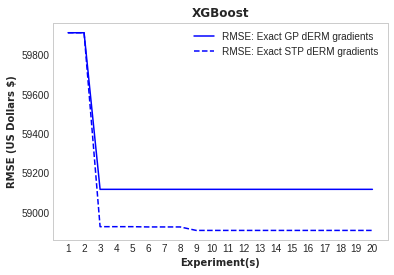

In [67]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_gp, color = 'Blue', label='RMSE: Exact GP dERM gradients')
plt.plot(min_rmse_stp, color = 'Blue', label='RMSE: Exact STP dERM gradients', ls='--')# r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('Experiment(s)', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('RMSE (US Dollars $)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_gp)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.grid(b=None)
plt.show() #visualize!


In [68]:
time_gp, time_stp


(1769.6654949188232, 1934.2644815444946)

In [69]:
min(min_rmse_stp), min(min_rmse_gp)


(58909.59940760899, 59117.95352067002)